In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import ElasticNet, Lasso, Ridge, LinearRegression, RidgeCV, LassoCV
from ipywidgets import *
from sklearn.model_selection import cross_val_score, cross_validate
from IPython.display import display
from typing import *
sns.set_style('darkgrid')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Importing Data

In [3]:
# read csv
portfolio = pd.read_csv(r"./48_Industry_Portfolios_Daily.csv", parse_dates=True, index_col="date")
portfolio = portfolio.reset_index(drop=False) 
# find the index of our end date
end_date_index = portfolio.index[portfolio['date'] == '20201231'][0] + 1
# drop the date column
portfolio.drop(columns=['date'], inplace=True)

# 2021-01-04 returns for first six industry for debugging purpose
return_jan_4 = [[-0.95, -1.02, -3.39, -2.28, -1.13, -2.97]]

## Domain

In [4]:
# mean_squared_error = []

# Parameters

num_of_alpha = 100
alpha_beginning = -5
alpha_end = 5
alpha_space = np.logspace(alpha_beginning,alpha_end,num_of_alpha)
n_industries = 6
n_samples = 63

# Fixed params for lasso and ridge - for unpacking later
lasso_params = {"fit_intercept": False, "normalize": False, "random_state":42, "tol": 0.1}
ridge_params = {"fit_intercept": False, "normalize": False, "store_cv_values": True}
ridge_kfold_params = {"fit_intercept": False, "normalize": False}

## Ridge, LASSO functions

In [5]:
# global variables
global end_date_index, return_jan_4

In [27]:
def duality_transform(R):
    """R is the dataframe we are using"""
    
    # Construct X and y from the dataset according to prof's notes
    num_samples, num_features = R.shape
    w_EW = np.ones(shape=(num_features, 1))
    w_EW = w_EW / num_features

    N = np.identity(n=(num_features - 1))
    N = np.insert(N, num_features - 1, -1, axis=0)

    X_train = np.matmul(R, N)
    y_train = np.matmul(R, w_EW)

    return X_train, y_train


def construct_X_y(df: pd.DataFrame, num_days_prior: int = 63, num_industries: int = 6):
    """Sample industries from the dataset"""
    
    # we can change num_days_prior to use different days: 63, 84 etc
    train = df.iloc[end_date_index - num_days_prior : end_date_index, :]
    
    # Randomly sample industries from the dataset
    train_sample = train.sample(n=num_industries, axis="columns", random_state=42)
    print(train_sample.columns)
    
    # Demean
    train_sample_demean = train_sample.sub(train_sample.mean())
    
    R = train_sample_demean.values
    
    # construct X_train, y_train
    X_train, y_train = duality_transform(R)

    return X_train, y_train


def cv_lasso(
    df: pd.DataFrame, num_days_prior: int = 63, num_industries: int = 6, num_folds: int = 10
):
    """Lasso using K fold cross validation"""
    
    
    X_train, y_train = construct_X_y(
        df=df, num_days_prior=num_days_prior, num_industries=num_industries
    )
    lasso = LassoCV(cv=num_folds, alphas = alpha_space, **lasso_params)
    lasso.fit(X_train, y_train.flatten())
    
    # call the mse_path_ method from the sklearn object to get the mse stored - similar to cv_scores
    mean = lasso.mse_path_.mean(axis=-1)
    std = lasso.mse_path_.std(axis=-1)
    
    coef_ = lasso.coef_
    # assert mean.shape == ()
    print(coef_)
    return mean, std

def cv_ridge(
    df: pd.DataFrame, num_days_prior: int = 63, num_industries: int = 6):

    X_train, y_train = construct_X_y(
        df=df, num_days_prior=num_days_prior, num_industries=num_industries
    )
    num_samples = X_train.shape[0]
    num_alphas = len(alpha_space)

    ridge = RidgeCV(alphas = alpha_space, **ridge_params)
    ridge.fit(X_train, y_train.flatten())

    cv_values = ridge.cv_values_.reshape((num_samples, num_alphas))
    mean = cv_values.mean(axis=0)
    std = cv_values.std(axis=0)
    # assert mean.shape == ()

    return mean, std

def display_plot(cv_scores, cv_scores_std, title = "6 Industries Lasso CV Plot",
                 xlim_min = np.log(alpha_space)[0],
                 xlim_max = np.log(alpha_space)[-1]):
    
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(np.log(alpha_space), cv_scores)

    std_error = cv_scores_std / np.sqrt(10)

    ax.fill_between(np.log(alpha_space), cv_scores + std_error, cv_scores - std_error, alpha=0.2)
    ax.set_ylabel("MSE")
    ax.set_xlabel("Log (Lambda)")
    ax.set_title(title)
    ax.axhline(np.max(cv_scores), linestyle="--", color=".5")
    ax.set_xlim([xlim_min, xlim_max])
    plt.plot(np.log(alpha_space), cv_scores + std_error, "b--")
    plt.plot(np.log(alpha_space), cv_scores - std_error, "b--")
    plt.show()



## Plots

### 63 Observations, 6 Industries

Index(['Mines', 'Whlsl', 'Gold ', 'Banks', 'Ships', 'Paper'], dtype='object')
[ 0.25220341 -0.          0.04926894  0.09627071  0.3099454 ]
Index(['Mines', 'Whlsl', 'Gold ', 'Banks', 'Ships', 'Paper'], dtype='object')


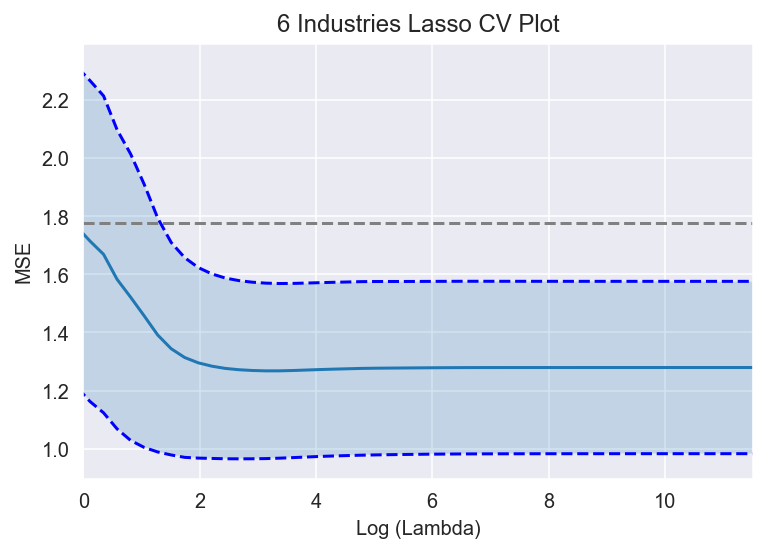

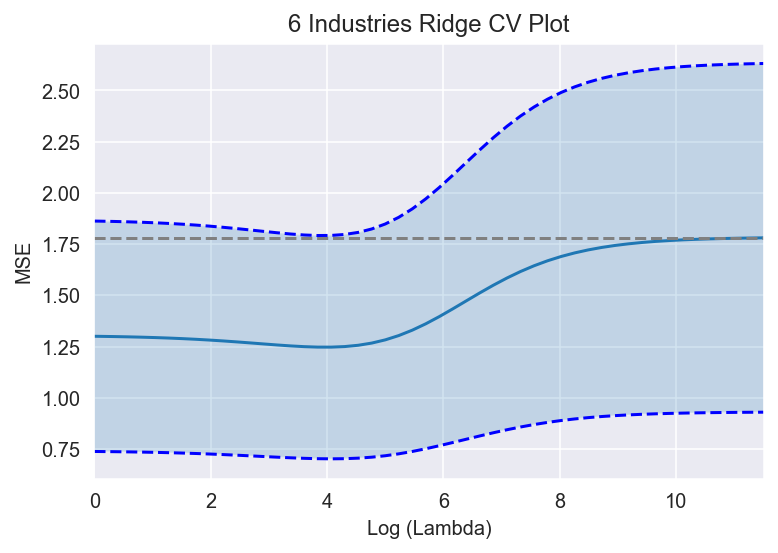

In [25]:
lasso_mean, lasso_std = cv_lasso(df=portfolio, num_days_prior=63, num_industries=6, num_folds=10)
ridge_mean, ridge_std = cv_ridge(df=portfolio, num_days_prior=63, num_industries=6)
display_plot(lasso_mean, lasso_std, title = "6 Industries Lasso CV Plot", xlim_min = 0)
display_plot(ridge_mean, ridge_std, title = "6 Industries Ridge CV Plot", xlim_min = 0)

### 63 Observations, 24 Industries

Index(['Mines', 'Whlsl', 'Gold ', 'Banks', 'Ships', 'Paper', 'Drugs', 'FabPr',
       'Smoke', 'Guns ', 'Hshld', 'Beer ', 'Fun  ', 'Trans', 'BusSv', 'Chems',
       'Cnstr', 'RlEst', 'Txtls', 'Clths', 'BldMt', 'Oil  ', 'PerSv', 'Fin  '],
      dtype='object')
[ 0.          0.          0.01404526  0.          0.         -0.
 -0.05406258  0.02612234 -0.         -0.03574917 -0.22506396 -0.
  0.01344938  0.          0.          0.          0.          0.02444169
  0.13569187  0.          0.          0.12180552  0.        ]
Index(['Mines', 'Whlsl', 'Gold ', 'Banks', 'Ships', 'Paper', 'Drugs', 'FabPr',
       'Smoke', 'Guns ', 'Hshld', 'Beer ', 'Fun  ', 'Trans', 'BusSv', 'Chems',
       'Cnstr', 'RlEst', 'Txtls', 'Clths', 'BldMt', 'Oil  ', 'PerSv', 'Fin  '],
      dtype='object')


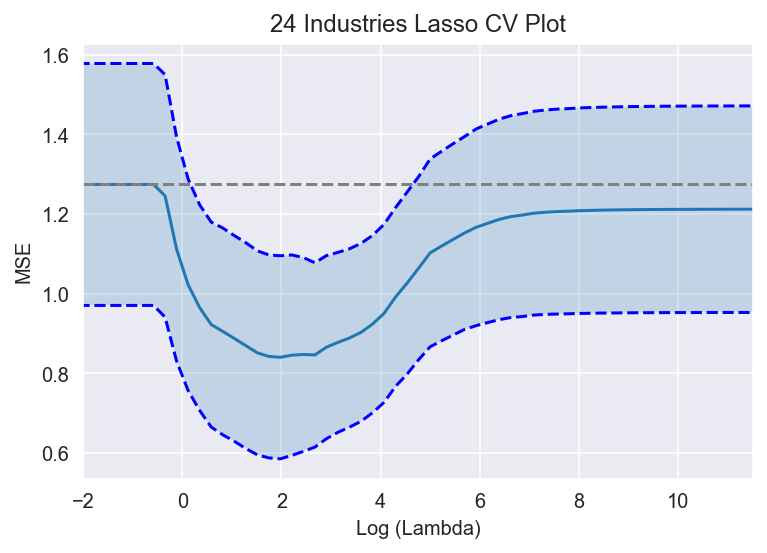

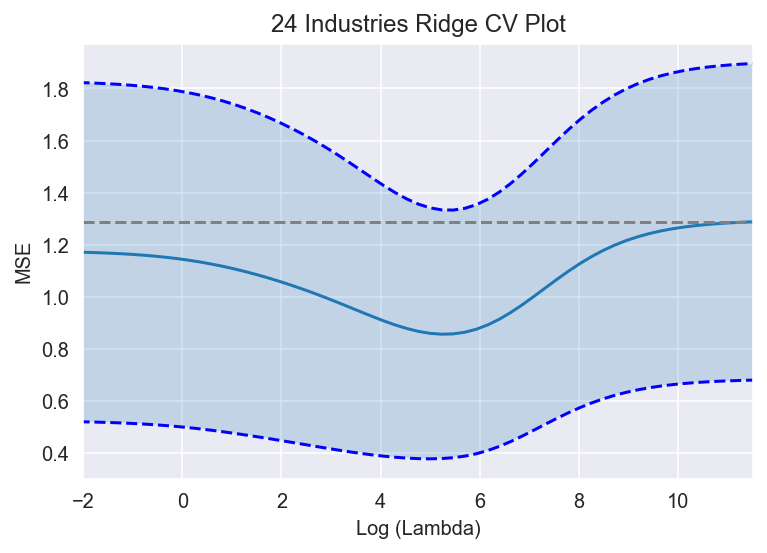

In [26]:
lasso_mean, lasso_std = cv_lasso(df=portfolio, num_days_prior=63, num_industries=24, num_folds=10)
ridge_mean, ridge_std = cv_ridge(df=portfolio, num_days_prior=63, num_industries=24)
display_plot(lasso_mean, lasso_std, title = "24 Industries Lasso CV Plot", xlim_min = -2)
display_plot(ridge_mean, ridge_std, title = "24 Industries Ridge CV Plot", xlim_min = -2)

### 63 Observations, 48 Industries

Index(['Mines', 'Whlsl', 'Gold ', 'Banks', 'Ships', 'Paper', 'Drugs', 'FabPr',
       'Smoke', 'Guns ', 'Hshld', 'Beer ', 'Fun  ', 'Trans', 'BusSv', 'Chems',
       'Cnstr', 'RlEst', 'Txtls', 'Clths', 'BldMt', 'Oil  ', 'PerSv', 'Fin  ',
       'Agric', 'Telcm', 'Util ', 'Toys ', 'MedEq', 'Comps', 'Food ', 'Insur',
       'ElcEq', 'Soda ', 'LabEq', 'Chips', 'Aero ', 'Rtail', 'Hlth ', 'Autos',
       'Steel', 'Other', 'Mach ', 'Books', 'Meals', 'Rubbr', 'Coal ', 'Boxes'],
      dtype='object')
[-0.          0.          0.         -0.         -0.         -0.08974967
 -0.03209364 -0.         -0.0234005  -0.08374613 -0.20707048 -0.0019887
  0.          0.          0.         -0.         -0.         -0.
  0.08550145 -0.          0.          0.11073645 -0.         -0.
 -0.         -0.05495028 -0.11856939 -0.0002338  -0.          0.02874981
 -0.          0.         -0.         -0.          0.          0.07265392
  0.02922074  0.         -0.          0.0109755   0.07343713 -0.
  0.         -0. 

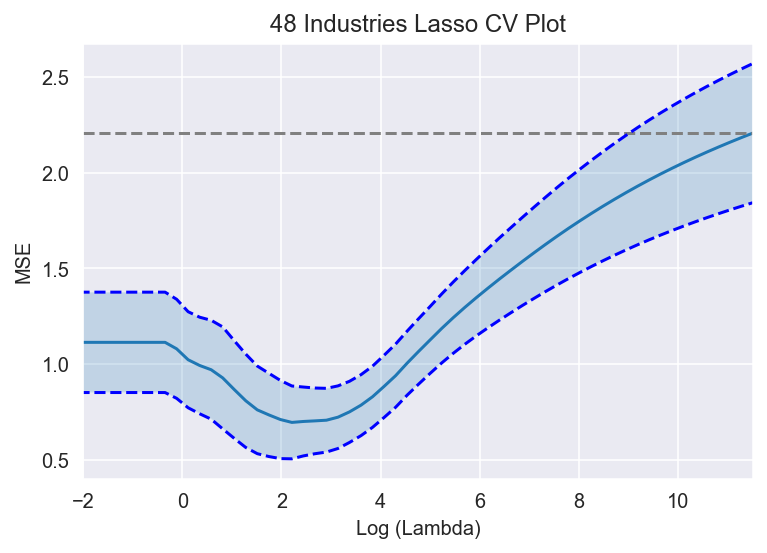

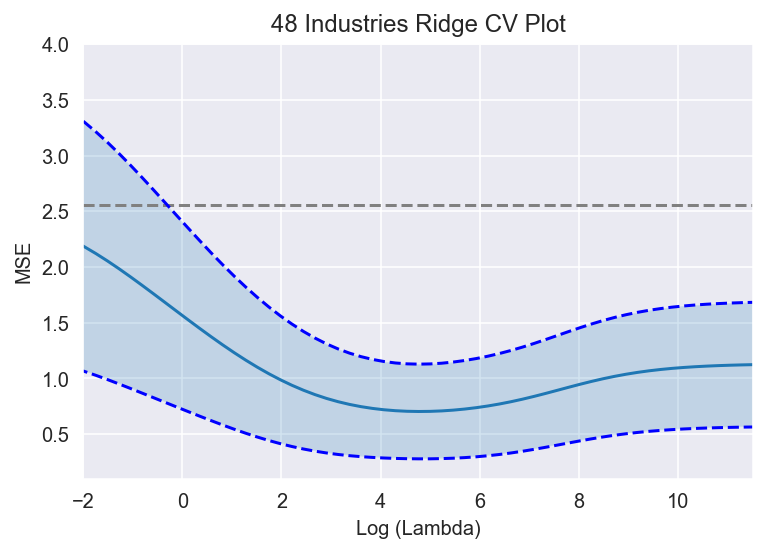

In [28]:
lasso_mean, lasso_std = cv_lasso(df=portfolio, num_days_prior=63, num_industries=48, num_folds=10)
ridge_mean, ridge_std = cv_ridge(df=portfolio, num_days_prior=63, num_industries=48)
display_plot(lasso_mean, lasso_std, title = "48 Industries Lasso CV Plot", xlim_min = -2)
display_plot(ridge_mean, ridge_std, title = "48 Industries Ridge CV Plot", xlim_min = -2)

### 42 Observations, 6 Industries

Index(['Mines', 'Whlsl', 'Gold ', 'Banks', 'Ships', 'Paper'], dtype='object')
[ 0.22262081 -0.          0.04770255  0.05616937  0.31621173]
Index(['Mines', 'Whlsl', 'Gold ', 'Banks', 'Ships', 'Paper'], dtype='object')


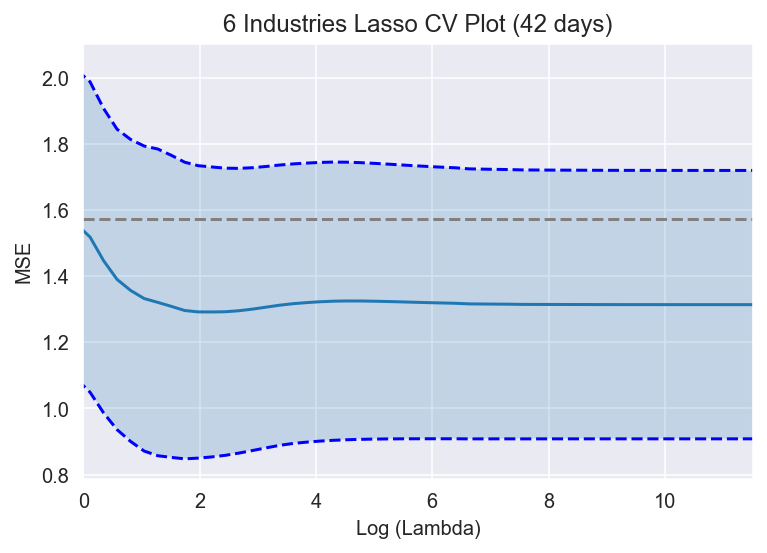

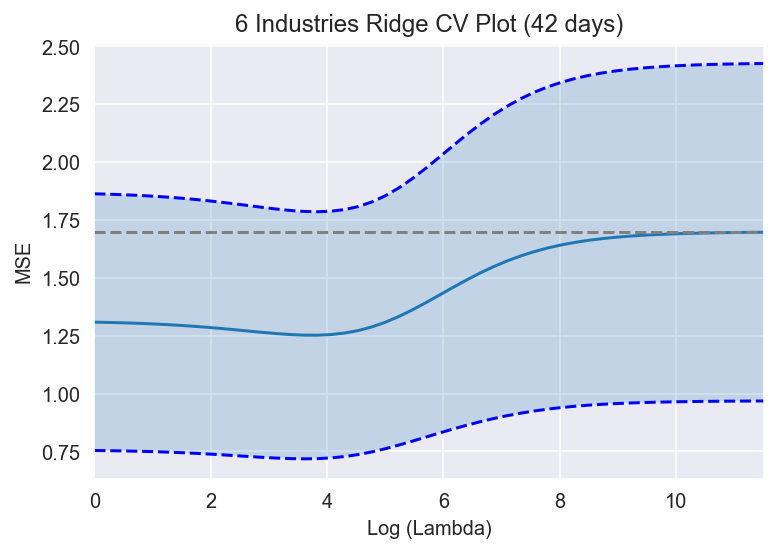

In [31]:
lasso_mean, lasso_std = cv_lasso(df=portfolio, num_days_prior=42, num_industries=6, num_folds=10)
ridge_mean, ridge_std = cv_ridge(df=portfolio, num_days_prior=42, num_industries=6)
display_plot(lasso_mean, lasso_std, title = "6 Industries Lasso CV Plot (42 days)", xlim_min = 0)
display_plot(ridge_mean, ridge_std, title = "6 Industries Ridge CV Plot (42 days)", xlim_min = 0)

### 42 Observations, 24 Industries

Index(['Mines', 'Whlsl', 'Gold ', 'Banks', 'Ships', 'Paper', 'Drugs', 'FabPr',
       'Smoke', 'Guns ', 'Hshld', 'Beer ', 'Fun  ', 'Trans', 'BusSv', 'Chems',
       'Cnstr', 'RlEst', 'Txtls', 'Clths', 'BldMt', 'Oil  ', 'PerSv', 'Fin  '],
      dtype='object')
[-0.          0.          0.         -0.          0.         -0.
 -0.12996734  0.02437275 -0.         -0.0858267  -0.1297419  -0.
 -0.         -0.         -0.          0.         -0.          0.
  0.18604567 -0.          0.          0.08853593  0.        ]
Index(['Mines', 'Whlsl', 'Gold ', 'Banks', 'Ships', 'Paper', 'Drugs', 'FabPr',
       'Smoke', 'Guns ', 'Hshld', 'Beer ', 'Fun  ', 'Trans', 'BusSv', 'Chems',
       'Cnstr', 'RlEst', 'Txtls', 'Clths', 'BldMt', 'Oil  ', 'PerSv', 'Fin  '],
      dtype='object')


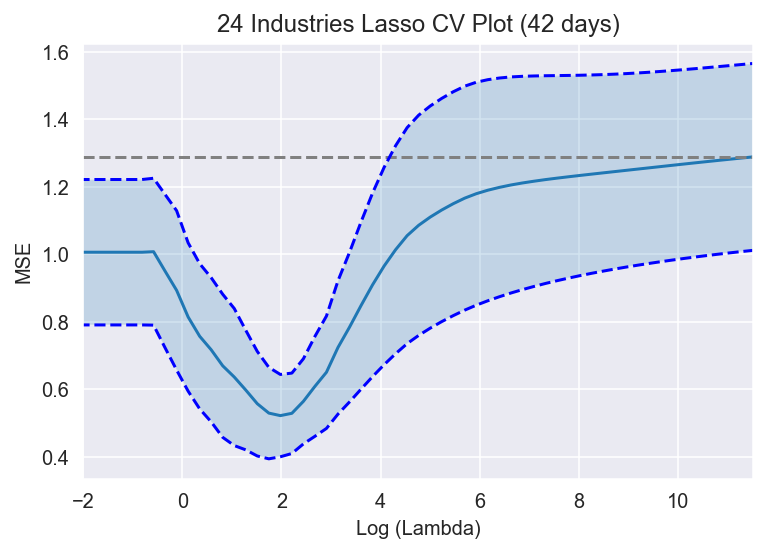

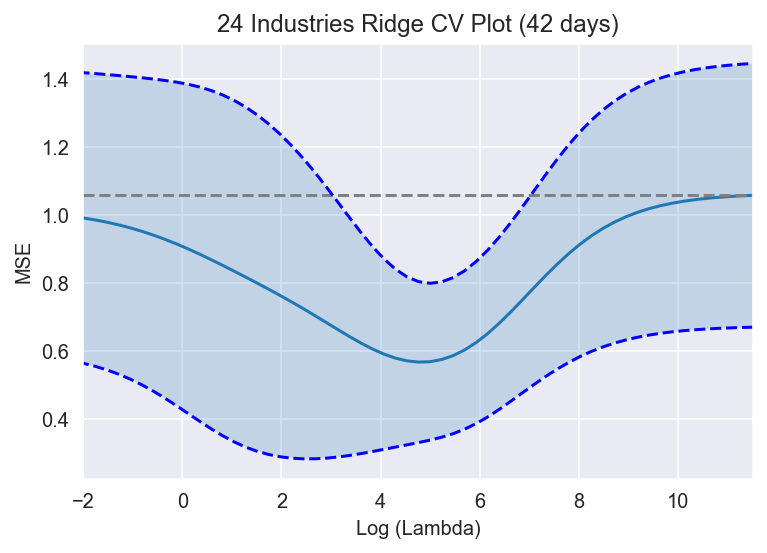

In [30]:
lasso_mean, lasso_std = cv_lasso(df=portfolio, num_days_prior=42, num_industries=24, num_folds=10)
ridge_mean, ridge_std = cv_ridge(df=portfolio, num_days_prior=42, num_industries=24)
display_plot(lasso_mean, lasso_std, title = "24 Industries Lasso CV Plot (42 days)", xlim_min = -2)
display_plot(ridge_mean, ridge_std, title = "24 Industries Ridge CV Plot (42 days)", xlim_min = -2)

### 42 Observations, 48 Industries

Index(['Mines', 'Whlsl', 'Gold ', 'Banks', 'Ships', 'Paper', 'Drugs', 'FabPr',
       'Smoke', 'Guns ', 'Hshld', 'Beer ', 'Fun  ', 'Trans', 'BusSv', 'Chems',
       'Cnstr', 'RlEst', 'Txtls', 'Clths', 'BldMt', 'Oil  ', 'PerSv', 'Fin  ',
       'Agric', 'Telcm', 'Util ', 'Toys ', 'MedEq', 'Comps', 'Food ', 'Insur',
       'ElcEq', 'Soda ', 'LabEq', 'Chips', 'Aero ', 'Rtail', 'Hlth ', 'Autos',
       'Steel', 'Other', 'Mach ', 'Books', 'Meals', 'Rubbr', 'Coal ', 'Boxes'],
      dtype='object')
[-0.07849238  0.          0.         -0.         -0.         -0.
 -0.06268131 -0.         -0.09913555 -0.11403157 -0.         -0.05092159
 -0.         -0.         -0.         -0.         -0.          0.
  0.09540463 -0.01173216  0.          0.13314611  0.         -0.
  0.         -0.09785668 -0.         -0.06354201 -0.          0.
 -0.          0.          0.         -0.          0.          0.
  0.         -0.         -0.         -0.          0.01454086 -0.
  0.         -0.         -0.         -0.

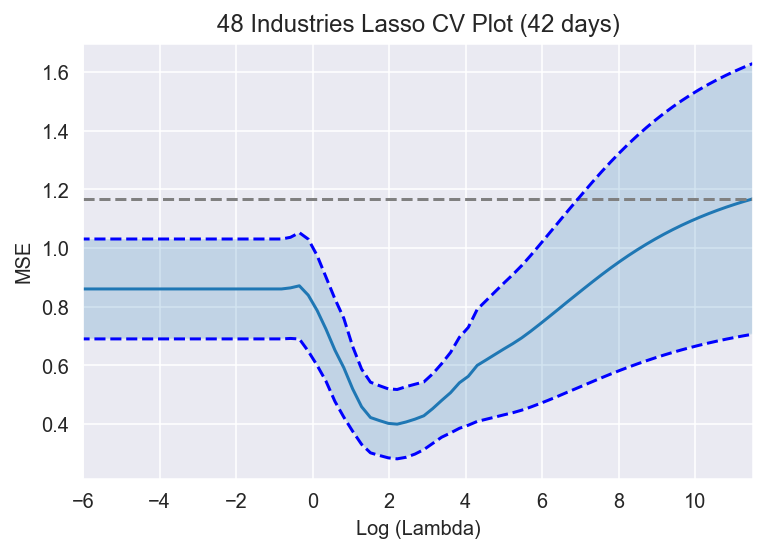

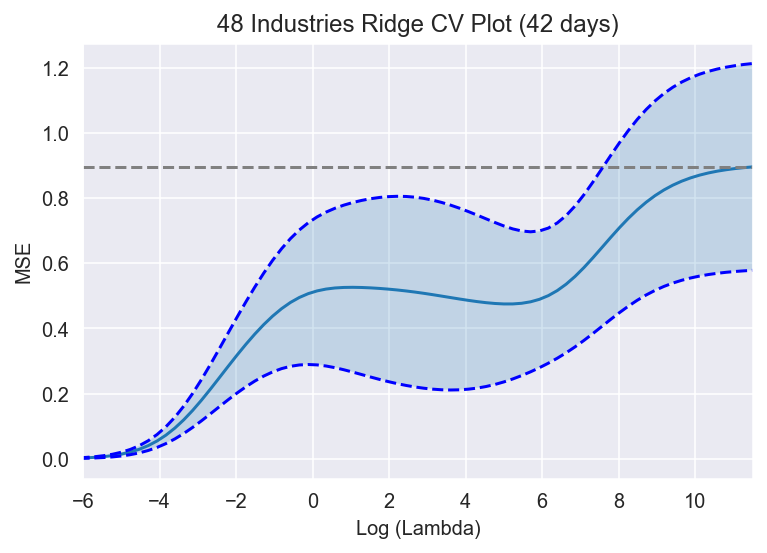

In [32]:
lasso_mean, lasso_std = cv_lasso(df=portfolio, num_days_prior=42, num_industries=48, num_folds=10)
ridge_mean, ridge_std = cv_ridge(df=portfolio, num_days_prior=42, num_industries=48)
display_plot(lasso_mean, lasso_std, title = "48 Industries Lasso CV Plot (42 days)", xlim_min = -6)
display_plot(ridge_mean, ridge_std, title = "48 Industries Ridge CV Plot (42 days)", xlim_min = -6)

### 84 Observations, 6 Industries

Index(['Mines', 'Whlsl', 'Gold ', 'Banks', 'Ships', 'Paper'], dtype='object')
[ 0.31875223 -0.          0.04016712  0.04671395  0.34099265]
Index(['Mines', 'Whlsl', 'Gold ', 'Banks', 'Ships', 'Paper'], dtype='object')


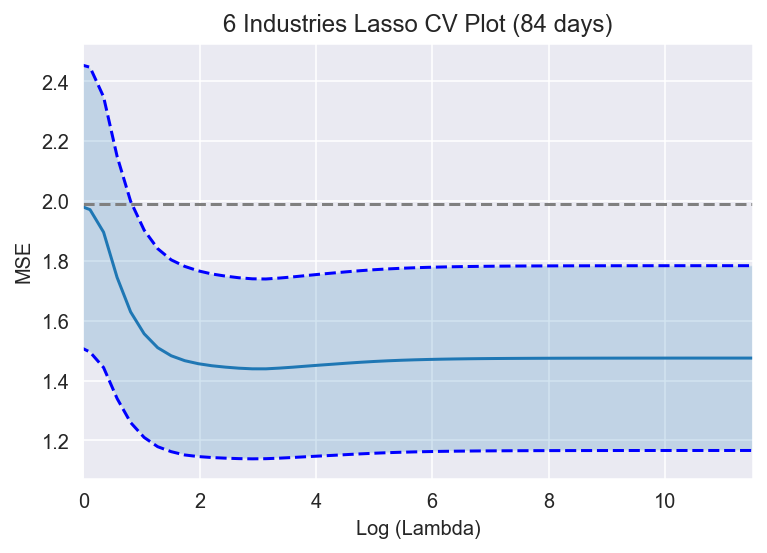

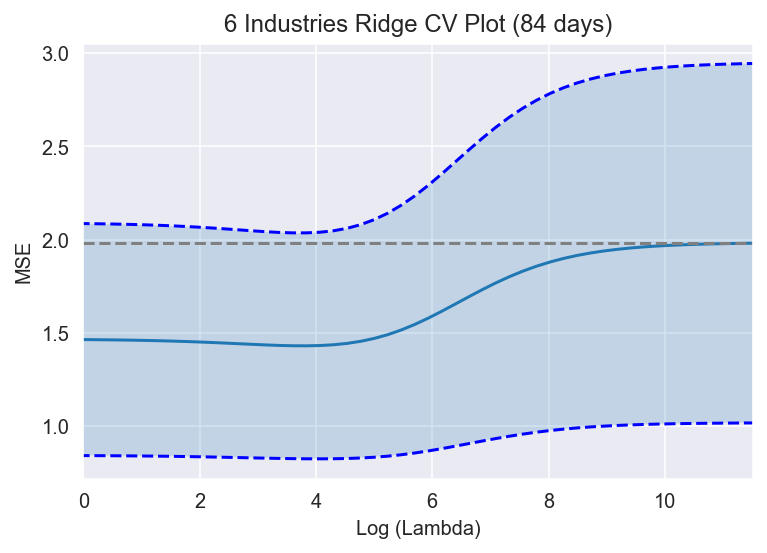

In [33]:
lasso_mean, lasso_std = cv_lasso(df=portfolio, num_days_prior=84, num_industries=6, num_folds=10)
ridge_mean, ridge_std = cv_ridge(df=portfolio, num_days_prior=84, num_industries=6)
display_plot(lasso_mean, lasso_std, title = "6 Industries Lasso CV Plot (84 days)", xlim_min = 0)
display_plot(ridge_mean, ridge_std, title = "6 Industries Ridge CV Plot (84 days)", xlim_min = 0)

### 84 Observations, 24 Industries

Index(['Mines', 'Whlsl', 'Gold ', 'Banks', 'Ships', 'Paper', 'Drugs', 'FabPr',
       'Smoke', 'Guns ', 'Hshld', 'Beer ', 'Fun  ', 'Trans', 'BusSv', 'Chems',
       'Cnstr', 'RlEst', 'Txtls', 'Clths', 'BldMt', 'Oil  ', 'PerSv', 'Fin  '],
      dtype='object')
[ 0.02565171  0.16986646  0.04396242  0.          0.         -0.0090923
 -0.13045286  0.01185992 -0.07575872 -0.         -0.63242983 -0.
  0.00448881 -0.          0.21202638  0.02914562  0.          0.01026567
  0.12172242 -0.03743139  0.22331698  0.0888278   0.        ]
Index(['Mines', 'Whlsl', 'Gold ', 'Banks', 'Ships', 'Paper', 'Drugs', 'FabPr',
       'Smoke', 'Guns ', 'Hshld', 'Beer ', 'Fun  ', 'Trans', 'BusSv', 'Chems',
       'Cnstr', 'RlEst', 'Txtls', 'Clths', 'BldMt', 'Oil  ', 'PerSv', 'Fin  '],
      dtype='object')


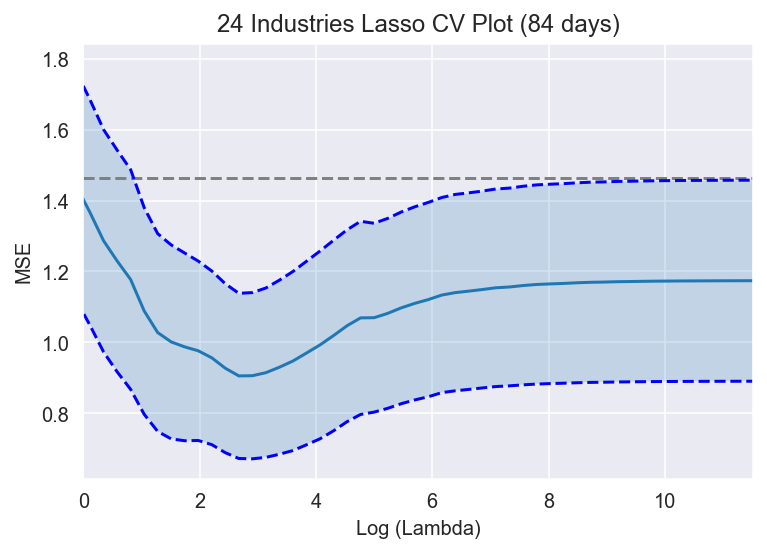

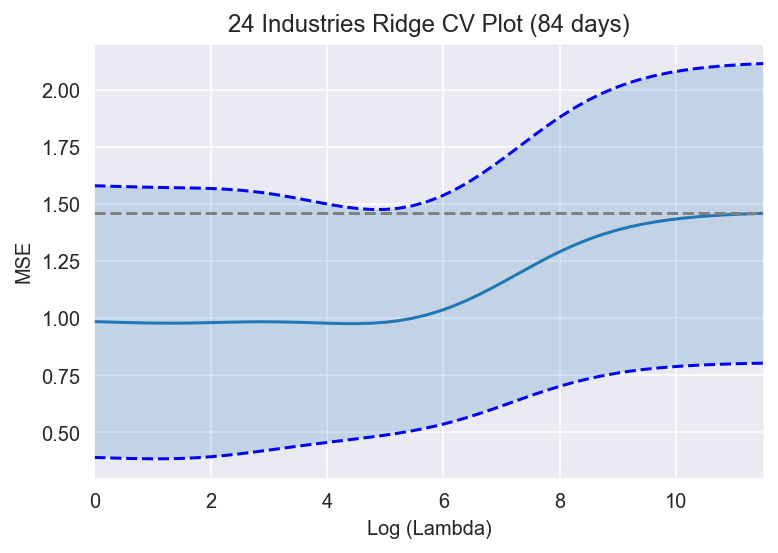

In [34]:
lasso_mean, lasso_std = cv_lasso(df=portfolio, num_days_prior=84, num_industries=24, num_folds=10)
ridge_mean, ridge_std = cv_ridge(df=portfolio, num_days_prior=84, num_industries=24)
display_plot(lasso_mean, lasso_std, title = "24 Industries Lasso CV Plot (84 days)", xlim_min = 0)
display_plot(ridge_mean, ridge_std, title = "24 Industries Ridge CV Plot (84 days)", xlim_min = 0)

### 84 Observations, 48 Industries

Index(['Mines', 'Whlsl', 'Gold ', 'Banks', 'Ships', 'Paper', 'Drugs', 'FabPr',
       'Smoke', 'Guns ', 'Hshld', 'Beer ', 'Fun  ', 'Trans', 'BusSv', 'Chems',
       'Cnstr', 'RlEst', 'Txtls', 'Clths', 'BldMt', 'Oil  ', 'PerSv', 'Fin  ',
       'Agric', 'Telcm', 'Util ', 'Toys ', 'MedEq', 'Comps', 'Food ', 'Insur',
       'ElcEq', 'Soda ', 'LabEq', 'Chips', 'Aero ', 'Rtail', 'Hlth ', 'Autos',
       'Steel', 'Other', 'Mach ', 'Books', 'Meals', 'Rubbr', 'Coal ', 'Boxes'],
      dtype='object')
[-0.00000000e+00  0.00000000e+00  0.00000000e+00  2.36516499e-02
  0.00000000e+00 -5.77923234e-02 -9.20580483e-02  5.95787516e-05
 -6.34741605e-02 -0.00000000e+00 -4.08092015e-01 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  8.76280881e-02  0.00000000e+00
  1.45910117e-02  2.31177373e-02  1.16178223e-01 -1.72001282e-02
  2.88682913e-02  7.68840220e-02  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -1.32467796e-01 -5.69979136e-02 -2.98971178e-02
  0.00000000e+00  2.19382876e-01 -0.00000000e+00

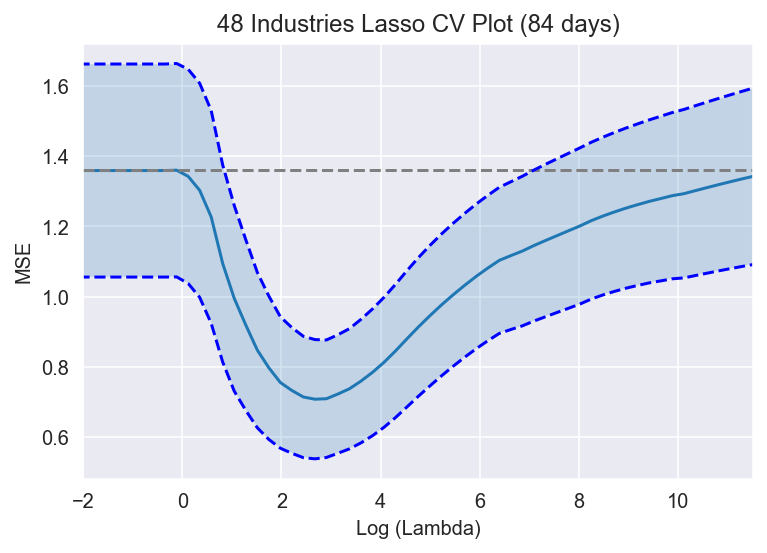

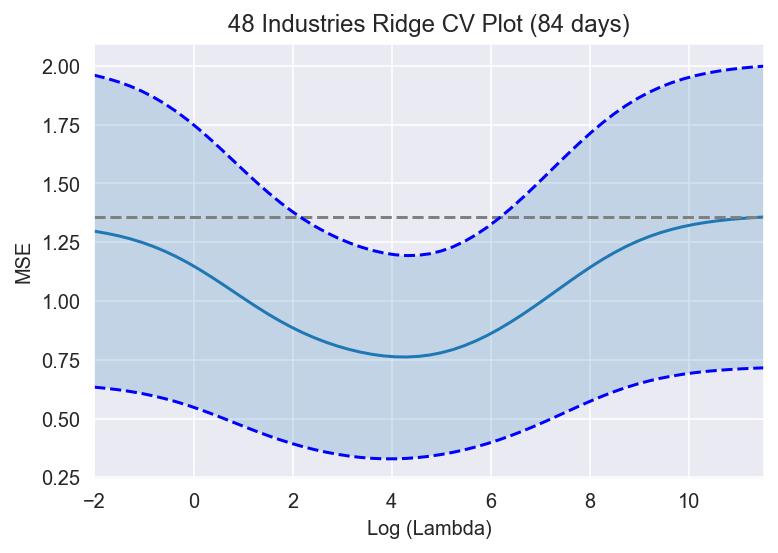

In [35]:
lasso_mean, lasso_std = cv_lasso(df=portfolio, num_days_prior=84, num_industries=48, num_folds=10)
ridge_mean, ridge_std = cv_ridge(df=portfolio, num_days_prior=84, num_industries=48)
display_plot(lasso_mean, lasso_std, title = "48 Industries Lasso CV Plot (84 days)", xlim_min = -2)
display_plot(ridge_mean, ridge_std, title = "48 Industries Ridge CV Plot (84 days)", xlim_min = -2)

### 500 Observations, 48 Industries

Index(['Mines', 'Whlsl', 'Gold ', 'Banks', 'Ships', 'Paper'], dtype='object')
[ 0.3777035  -0.26486345 -0.09541619  0.37778928  0.17839484]
Index(['Mines', 'Whlsl', 'Gold ', 'Banks', 'Ships', 'Paper'], dtype='object')


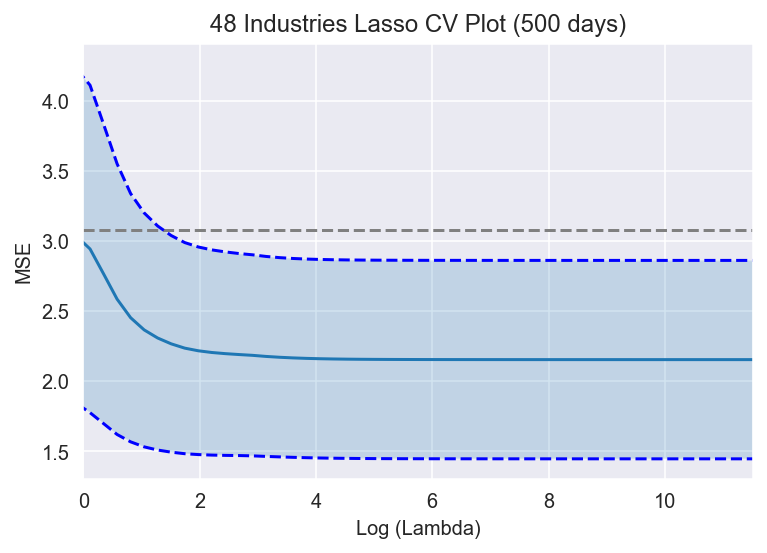

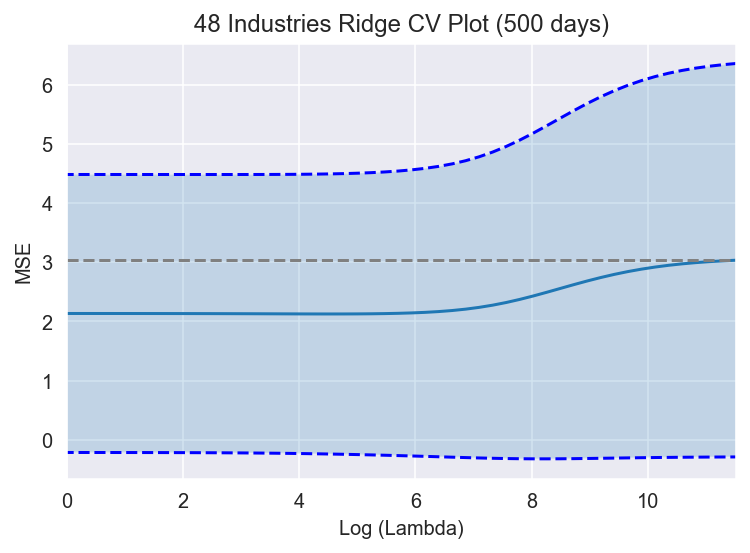

In [36]:
lasso_mean, lasso_std = cv_lasso(df=portfolio, num_days_prior=500, num_industries=6, num_folds=10)
ridge_mean, ridge_std = cv_ridge(df=portfolio, num_days_prior=500, num_industries=6)
display_plot(lasso_mean, lasso_std, title = "48 Industries Lasso CV Plot (500 days)", xlim_min = 0)
display_plot(ridge_mean, ridge_std, title = "48 Industries Ridge CV Plot (500 days)", xlim_min = 0)